In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from wisard.encoders import ThermometerEncoder
from wisard.wisard import WiSARD

%matplotlib inline

In [3]:
def sample_digit(target: int, X, y):
    return next(
        (digit for (digit, label) in zip(X, y) if int(label) == int(target))
    ).reshape((28, 28))


def display_mnist_digits(X, y):
    fig, axs = plt.subplots(2, 5)

    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(sample_digit(target=5 * i + j, X=X, y=y), cmap="seismic")
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
    plt.show()


def train_model(model: WiSARD, X: np.ndarray, y: np.ndarray):
    for d in tqdm.tqdm(range(len(X)), desc="Training model"):
        model.train(X[d], y[d])


def evaluate_model(model, X, y, bleach: int = 1):
    model.set_bleaching(bleach)
    y_pred = [model.predict(x) for x in tqdm.tqdm(X, desc="Evaluating dataset")]
    return y_pred


def untie(y_pred):
    final_pred = []
    ties = 0
    for pred in tqdm.tqdm(y_pred, desc="Untieing"):
        if len(pred) > 1:
            ties += 1
            final_pred.append(pred[random.randint(0, len(pred) - 1)])
        else:
            final_pred.append(pred[0])

    return np.array(final_pred), ties

In [4]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

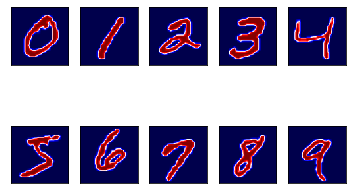

In [5]:
display_mnist_digits(X.values, y)

## Encoding example

Let's encode data with Thermometer

In [6]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=16)
thermometer

ThermometerEncoder(minimum=0, maximum=255, resolution=16)

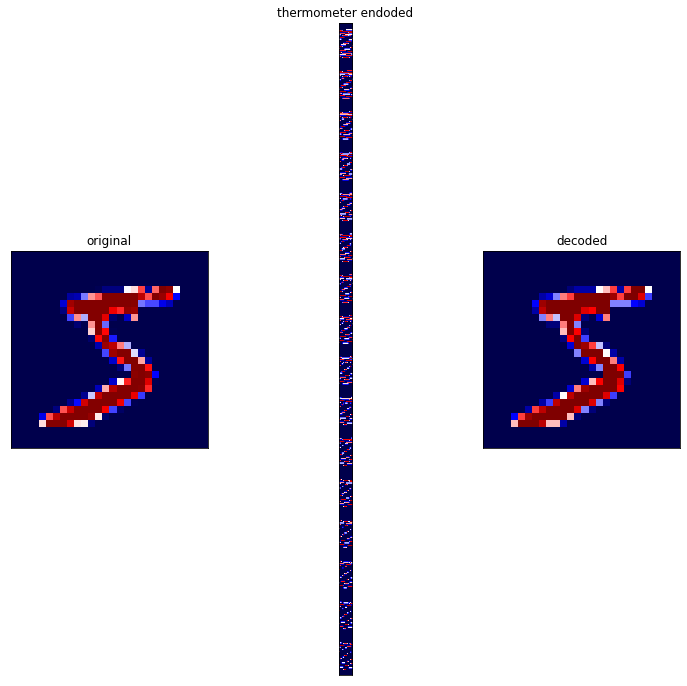

In [7]:
digit = X.values[0]
encoded_digit = thermometer.encode(digit)
decoded_digit = thermometer.decode(encoded_digit)

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(12, 12))

for i, (im, shape, name) in enumerate(
    [
        (digit, (28, 28), "original"),
        (encoded_digit, (28 * 28, 16), "thermometer endoded"),
        (decoded_digit, (28, 28), "decoded"),
    ]
):
    axs[0, i].imshow(im.reshape(shape), cmap="seismic")
    axs[0, i].set_title(name)
    axs[0, i].axes.xaxis.set_visible(False)
    axs[0, i].axes.yaxis.set_visible(False)

plt.show()

In [8]:
coded_X = []
for x in tqdm.tqdm(X.values, desc="Encoding dataset"):
    coded_X.append(thermometer.encode(x).ravel())

coded_X = np.array(coded_X)
y = np.array([int(label) for label in y.values])
print(coded_X.shape)

Encoding dataset: 100%|██████████████████████████████████████| 70000/70000 [00:06<00:00, 10863.40it/s]


(70000, 12544)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    coded_X, y, test_size=0.10, stratify=y
)

# Creating WiSARD

In [10]:
shared_rand_vals = True  # not used...
input_size = X_train[0].size
num_classes = 10
tuple_size = 16
unit_entries = 1   # Only used for BloomFilter
unit_hashes = 1    # Only used for BloomFilter
input_idxs = np.random.shuffle(np.arange(input_size))  # Order to select elements
randomize = False   # Randomize selection order?

In [11]:
model = WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=False
)

In [12]:
X_train[0].shape

(12544,)

In [13]:
train_model(model, X_train, y_train)

Training model: 100%|██████████████████████████████████████████| 63000/63000 [01:46<00:00, 589.78it/s]


In [14]:
y_pred = evaluate_model(model, X_test, y_test, bleach=50)

Evaluating dataset: 100%|█████████████████████████████████████████| 7000/7000 [01:11<00:00, 98.59it/s]


In [15]:
y_pred, ties = untie(y_pred)
print(classification_report(y_test, y_pred))
print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")

Untieing: 100%|██████████████████████████████████████████████| 7000/7000 [00:00<00:00, 2157880.93it/s]

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       690
           1       0.93      0.94      0.93       788
           2       0.88      0.87      0.87       699
           3       0.77      0.93      0.85       714
           4       0.91      0.90      0.91       682
           5       0.91      0.86      0.88       631
           6       0.96      0.92      0.94       688
           7       0.91      0.84      0.87       729
           8       0.89      0.78      0.83       683
           9       0.82      0.84      0.83       696

    accuracy                           0.88      7000
   macro avg       0.89      0.88      0.88      7000
weighted avg       0.89      0.88      0.88      7000

Ties: 29 (0.4143%)


# Mental images

In [16]:
imgs = model.mental_images()

Extracting mental images: 100%|███████████████████████████████████████| 10/10 [06:59<00:00, 41.96s/it]


In [17]:
decoded_imgs = [thermometer.decode(im.reshape(16, 784)) for im in imgs]

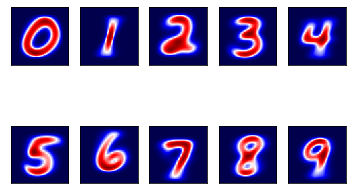

In [18]:
display_mnist_digits(
    X=decoded_imgs, y=list(range(10))
)

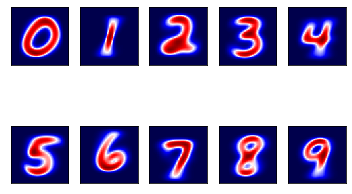

In [19]:
normalized_decoded_imgs = [
    (dec_img * (thermometer.maximum/dec_img.max())).astype("int")
    for dec_img in decoded_imgs
]

display_mnist_digits(
    X=normalized_decoded_imgs, y=list(range(10))
)

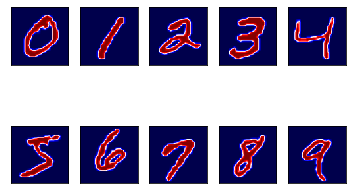

In [20]:
display_mnist_digits(X=X.values, y=y)

# Create a new WiSARD based on the mental images

In [21]:
def model_from_mental_image(model: WiSARD, encoder, mental_imgs: np.ndarray):
    for d_no, mental_img in enumerate(mental_imgs):
        norm_mental_img = mental_img * (encoder.maximum/mental_img.max())
        norm_mental_img = norm_mental_img.astype("int")
        num_filters = model.discriminators[d_no].num_filters
        coded_img = encoder.encode(norm_mental_img).ravel()
        coded_img = np.pad(coded_img, (0, model.pad_zeros))[model.input_order]
        coded_inputs = coded_img.reshape(num_filters, -1)
        for f_no, value in enumerate(coded_inputs):
            inc_val = int(mental_img[f_no])
            model.discriminators[d_no].filters[f_no].add_member(value, inc_val)

## Experiment 1: Replicating WiSARD based on mental images

The mapping is the same. The encoder/decoder method is the same (thermometer). The tuple size is the same.

In [22]:
model = WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=False
)

model_from_mental_image(model, thermometer, decoded_imgs)

In [23]:
y_pred = evaluate_model(model, X_test, y_test, bleach=200)
y_pred, ties = untie(y_pred)
print(classification_report(y_test, y_pred))
print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")

Untieing: 100%|██████████████████████████████████████████████| 7000/7000 [00:00<00:00, 2677133.95it/s]

              precision    recall  f1-score   support

           0       1.00      0.07      0.14       690
           1       0.73      0.91      0.81       788
           2       0.76      0.44      0.56       699
           3       0.84      0.49      0.62       714
           4       0.21      0.94      0.34       682
           5       0.56      0.33      0.42       631
           6       0.95      0.46      0.62       688
           7       0.53      0.79      0.63       729
           8       0.79      0.22      0.34       683
           9       0.90      0.04      0.07       696

    accuracy                           0.48      7000
   macro avg       0.73      0.47      0.45      7000
weighted avg       0.73      0.48      0.46      7000

Ties: 215 (3.0714%)


## Experiment 2: Replicating WiSARD based on mental images with random mapping

The mapping is made in a random way. The encoder/decoder method is the same (thermometer). The tuple size the same

In [24]:
model = WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=True
)

model_from_mental_image(model, thermometer, decoded_imgs)

In [25]:
y_pred = evaluate_model(model, X_test, y_test, bleach=200)
y_pred, ties = untie(y_pred)
print(classification_report(y_test, y_pred))
print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")

Untieing: 100%|██████████████████████████████████████████████| 7000/7000 [00:00<00:00, 1087532.99it/s]

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       690
           1       0.27      1.00      0.42       788
           2       0.98      0.35      0.51       699
           3       0.71      0.46      0.56       714
           4       0.68      0.65      0.66       682
           5       0.80      0.15      0.25       631
           6       0.81      0.69      0.74       688
           7       0.85      0.71      0.77       729
           8       0.78      0.26      0.39       683
           9       0.63      0.57      0.60       696

    accuracy                           0.57      7000
   macro avg       0.74      0.56      0.57      7000
weighted avg       0.74      0.57      0.58      7000

Ties: 170 (2.4286%)


## Experiment 3: Replicating WiSARD based on mental images with different tuple size

The mapping is made in a random way. The encoder/decoder method is the same (thermometer). The tuple size is different.

In [26]:
new_resolution = 12
encoder = ThermometerEncoder(minimum=0, maximum=255, resolution=new_resolution)
new_num_inputs = encoder.encode(decoded_imgs[0]).size

print(new_num_inputs, new_resolution)

9408 12


In [27]:
model = WiSARD(
    num_inputs=new_num_inputs,
    num_classes=num_classes,
    unit_inputs=new_resolution,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=None,
    shared_rand_vals=shared_rand_vals,
    randomize=True
)


model_from_mental_image(model, encoder, decoded_imgs)

In [28]:
y_pred = evaluate_model(model, X_test, y_test, bleach=200)
y_pred, ties = untie(y_pred)
print(classification_report(y_test, y_pred))
print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")

Untieing: 100%|██████████████████████████████████████████████| 7000/7000 [00:00<00:00, 1922480.88it/s]

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       690
           1       0.33      0.99      0.49       788
           2       0.93      0.45      0.60       699
           3       0.69      0.60      0.64       714
           4       0.65      0.72      0.68       682
           5       0.78      0.29      0.43       631
           6       0.86      0.71      0.78       688
           7       0.76      0.71      0.73       729
           8       0.85      0.32      0.46       683
           9       0.64      0.59      0.62       696

    accuracy                           0.62      7000
   macro avg       0.75      0.61      0.63      7000
weighted avg       0.74      0.62      0.63      7000

Ties: 137 (1.9571%)


## Few future ideas and notes

- We can use synthetic data in order to improve the accuracy of the network whose received the weights. During the transfer learning process, instead of directly summing the value of the each pixel ofthe mental image in the correspoding RAM, we can use multiply by a coefficient (x), based on the maximum value of the image. The synthetic data, which is used to "train" (improve) the network, can have another coeeficient. During the training process, instead of sum 1 for each pixel, in the RAMs, we can sum a different value, based on: the number of inputs, the number of times the knownledge is transfered, etc. 

- Mental images may have high values, different from image.

- Thermometer encoding is not the best one for use for outliers.

- In a federated context, we can evaluate the mental images generated by a worker measuring the RMSE from the mental image of the worker and the mental image of a model trained with the whole data.

- Max pooling on mental images? How to use WiSARD as feature extractor? How to chain WiSARDs?

# Federated Wisards

In [29]:
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train)
Xs_train, ys_train = [X_train_1, X_train_2], [y_train_1, y_train_2]

## Experiment 1: Same architecture and hyper parameters

We will have: 1 Master and 2 slaves with the same architecture and hyperparameters. The dataset is balanced and stratified. The encoder/decoder is the same

In [30]:
number_of_models = 2

clients = [WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=False
) for i in range(number_of_models)]

In [32]:
for i, (m, X, y) in enumerate(zip(clients, Xs_train, ys_train)):
    print(f"{'-'*20} Model {i} {'-'*20}")
    train_model(m, X, y)
    y_pred = evaluate_model(m, X_test, y_test, bleach=30)
    y_pred, ties = untie(y_pred)
    print(classification_report(y_test, y_pred))
    print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")

-------------------- Model 0 --------------------


Untieing: 100%|██████████████████████████████████████████████| 7000/7000 [00:00<00:00, 2032405.37it/s]


              precision    recall  f1-score   support

           0       0.89      0.96      0.92       690
           1       0.91      0.94      0.92       788
           2       0.88      0.85      0.86       699
           3       0.76      0.92      0.83       714
           4       0.91      0.89      0.90       682
           5       0.89      0.84      0.87       631
           6       0.96      0.91      0.94       688
           7       0.90      0.84      0.87       729
           8       0.90      0.78      0.84       683
           9       0.82      0.84      0.83       696

    accuracy                           0.88      7000
   macro avg       0.88      0.88      0.88      7000
weighted avg       0.88      0.88      0.88      7000

Ties: 34 (0.4857%)
-------------------- Model 1 --------------------


Untieing: 100%|██████████████████████████████████████████████| 7000/7000 [00:00<00:00, 2864123.31it/s]


              precision    recall  f1-score   support

           0       0.90      0.95      0.93       690
           1       0.91      0.94      0.92       788
           2       0.89      0.85      0.87       699
           3       0.76      0.93      0.84       714
           4       0.92      0.90      0.91       682
           5       0.90      0.84      0.87       631
           6       0.95      0.92      0.94       688
           7       0.90      0.84      0.87       729
           8       0.90      0.79      0.84       683
           9       0.82      0.82      0.82       696

    accuracy                           0.88      7000
   macro avg       0.88      0.88      0.88      7000
weighted avg       0.88      0.88      0.88      7000

Ties: 40 (0.5714%)


-------------------- Model 0 --------------------



Extracting mental images: 100%|███████████████████████████████████████| 10/10 [07:31<00:00, 45.13s/it]


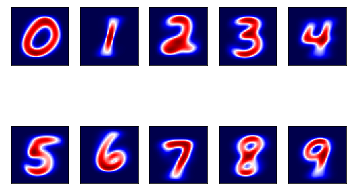

-------------------- Model 1 --------------------



Extracting mental images: 100%|███████████████████████████████████████| 10/10 [07:20<00:00, 44.01s/it]


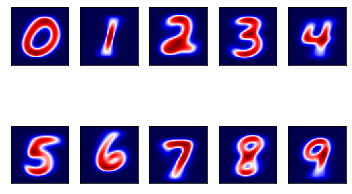

In [34]:
client_decoded_imgs = []
for i, c in enumerate(clients):
    print(f"{'-'*20} Model {i} {'-'*20}")
    imgs = c.mental_images()
    decoded_imgs = [thermometer.decode(im.reshape(16, 784)) for im in imgs]
    display_mnist_digits(
        X=decoded_imgs, y=list(range(10))
    )
    client_decoded_imgs.append(decoded_imgs)

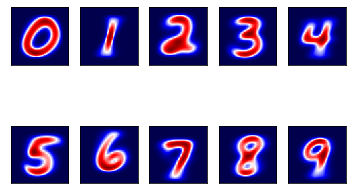

In [35]:
fused_decoded_imgs = [
    im1.ravel() + im2.ravel()
    for im1, im2 in zip(*client_decoded_imgs)
]

display_mnist_digits(
    X=fused_decoded_imgs, y=list(range(10))
)

In [36]:
model = WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=True
)

model_from_mental_image(model, thermometer, fused_decoded_imgs)

In [37]:
y_pred = evaluate_model(model, X_test, y_test, bleach=200)
y_pred, ties = untie(y_pred)
print(classification_report(y_test, y_pred))
print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")


Evaluating dataset: 100%|████████████████████████████████████████| 7000/7000 [01:07<00:00, 103.41it/s]

Untieing: 100%|██████████████████████████████████████████████| 7000/7000 [00:00<00:00, 2647680.40it/s]


              precision    recall  f1-score   support

           0       0.96      0.74      0.84       690
           1       0.27      1.00      0.43       788
           2       0.95      0.36      0.52       699
           3       0.69      0.49      0.57       714
           4       0.63      0.74      0.68       682
           5       0.75      0.22      0.34       631
           6       0.86      0.66      0.75       688
           7       0.83      0.67      0.74       729
           8       0.83      0.30      0.44       683
           9       0.64      0.45      0.53       696

    accuracy                           0.57      7000
   macro avg       0.74      0.56      0.58      7000
weighted avg       0.74      0.57      0.58      7000

Ties: 163 (2.3286%)


## Experiment 2: Same architecture and different hyper parameters (randomize inputs)

In [ ]:
number_of_models = 2

clients = [WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=True
) for i in range(number_of_models)]

In [ ]:
for i, (m, X, y) in enumerate(zip(clients, Xs_train, ys_train)):
    print(f"{'-'*20} Model {i} {'-'*20}")
    train_model(m, X, y)
    y_pred = evaluate_model(m, X_test, y_test, bleach=30)
    y_pred, ties = untie(y_pred)
    print(classification_report(y_test, y_pred))
    print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")

In [ ]:
client_decoded_imgs = []
for i, c in enumerate(clients):
    print(f"{'-'*20} Model {i} {'-'*20}")
    imgs = c.mental_images()
    decoded_imgs = [thermometer.decode(im.reshape(16, 784)) for im in imgs]
    display_mnist_digits(
        X=decoded_imgs, y=list(range(10))
    )
    client_decoded_imgs.append(decoded_imgs)

In [ ]:
fused_decoded_imgs = [
    im1.ravel() + im2.ravel()
    for im1, im2 in zip(*client_decoded_imgs)
]

display_mnist_digits(
    X=fused_decoded_imgs, y=list(range(10))
)

In [ ]:
model = WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=True
)

model_from_mental_image(model, thermometer, fused_decoded_imgs)

In [ ]:
y_pred = evaluate_model(model, X_test, y_test, bleach=200)
y_pred, ties = untie(y_pred)
print(classification_report(y_test, y_pred))
print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")